In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.feature_selection import RFE, RFECV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from data_dicts import drop_cols
from data_prep import county_info_2016, county_info_2018, results_info, create_targets
from model_prep import lin_mod_func, run_model, make_predictions
from visualizations import display_results

np.random.seed(2020)

## Data

The demographic information was obtained from the U.S. Cencus website. The 5 year study was used in order to obtain the most accurate information for smaller countues. The results data was obtained from the MIT Election Data and Science Lab.

In [2]:
features_2016 = county_info_2016()
features_2018 = county_info_2018()
results_2016 = results_info(2016)
# results_2012 = results_info(2012)

In [3]:
df = pd.merge(features_2016, results_2016, on='County')
df = create_targets(df)

# EDA

In [4]:
selected_features = ['Median age',
                     'Sex ratio (males per 100 females)',
                     'Households Median income',
                     'Percent Graduate or professional degree']

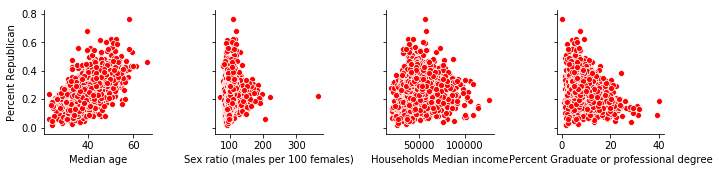

In [5]:
sns.pairplot(df, x_vars=selected_features, y_vars='Percent Republican', plot_kws={'color': 'red'});

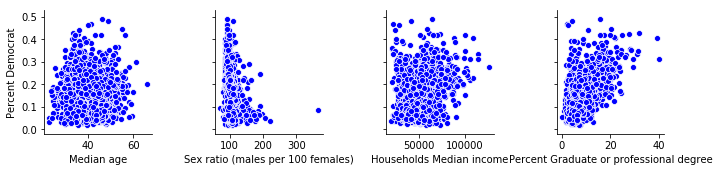

In [6]:
sns.pairplot(df, x_vars=selected_features, y_vars='Percent Democrat', plot_kws={'color': 'blue'});

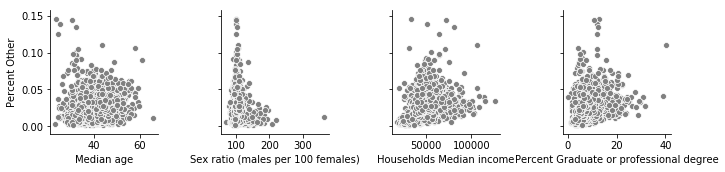

In [7]:
sns.pairplot(df, x_vars=selected_features, y_vars='Percent Other', plot_kws={'color': 'gray'});

In [8]:
#df['Percent Republican'].idxmax() 

In [9]:
#df['Percent Democrat'].idxmax()

In [10]:
#df['Percent Other'].idxmax()

In [11]:
#df.iloc[2653]

In [12]:
#df.iloc[1183]

In [13]:
#df.iloc[613]

## Methodology

In [14]:
y_R = df['Percent Republican']
y_D = df['Percent Democrat']
y_O = df['Percent Other']

X = df.drop(columns=drop_cols)

In [15]:
# Train Test Split for each party
X_train, X_test, y_train_R, y_test_R = train_test_split(X, y_R, random_state=2020)
X_train, X_test, y_train_D, y_test_D = train_test_split(X, y_D, random_state=2020)
X_train, X_test, y_train_O, y_test_O = train_test_split(X, y_O, random_state=2020)

In [16]:
R_model = lin_mod_func(X_train, X_test, y_train_R, y_test_R)

Training R^2 : 0.5007163542092132
Training Root Mean Square Error 0.05887295782337749
----------------
Testing R^2 : 0.4992196954893293
Testing Root Mean Square Error 0.06039318774712403


In [17]:
D_model = lin_mod_func(X_train, X_test, y_train_D, y_test_D)

Training R^2 : 0.42183613952790666
Training Root Mean Square Error 0.054539831213334077
----------------
Testing R^2 : 0.4297963268809938
Testing Root Mean Square Error 0.05738432591106083


In [18]:
O_model = lin_mod_func(X_train, X_test, y_train_O, y_test_O)

Training R^2 : 0.4869102901378374
Training Root Mean Square Error 0.010571099617328482
----------------
Testing R^2 : 0.4913023618008698
Testing Root Mean Square Error 0.010503622740706089


In [19]:
# Scale data
#scaler = StandardScaler()
# # mmscaler = MinMaxScaler()
#scaler.fit(X_train)
# X_train, X_test, y_train, y_test = train_test_split(X, y_R)

# for target in targets:

# linreg = LinearRegression()
# linreg.fit(X_train, y_train)

# run_model(linreg, X_train, X_test, y_train, y_test)

In [20]:
from sklearn.pipeline import Pipeline

pipe_scl_lin = Pipeline([('scl', StandardScaler()), ('lin', LinearRegression())])
pipe_mms_lin = Pipeline([('mms', MinMaxScaler()), ('lin', LinearRegression())])

pipelines = [pipe_scl_lin, pipe_mms_lin]
pipeline_names = ['Standard Scalar Linear','Min Max Linear']

y_trains = [y_train_R, y_train_D, y_train_O]
for y in y_trains: 
#for target in targets:
    for pipe in pipelines:
        print(pipe)
        pipe.fit(X_train, y)
    
# Compare accuracies
targets = [y_test_R, y_test_D, y_test_O]
for target in targets:
    for index, val in enumerate(pipelines):
        print('%s pipeline test accuracy: %.3f' % (pipeline_names[index],
                                                   val.score(X_test, target)))

Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lin',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Pipeline(memory=None,
         steps=[('mms', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('lin',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Pipeline(memory=None,
         steps=[('scl',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lin',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)
Pipeline(memory=None,
         steps=[('mms', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('lin'

## Evaluate model

In [21]:
# models = {R_model: y_train_R, D_model: y_train_D, O_model: y_train_O}
# for key, val in models:
#     cv_results = cross_validate(key, X_train, val, cv=3)
#     print(cv_results['test_score'])

In [22]:
cv_results = cross_validate(R_model, X_train, y_train_R, cv=3)
print(cv_results['test_score'])

[0.47340205 0.48222382 0.49402013]


In [23]:
cv_results = cross_validate(D_model, X_train, y_train_D, cv=3)
print(cv_results['test_score'])

[0.42324602 0.4049149  0.40000233]


In [24]:
cv_results = cross_validate(O_model, X_train, y_train_O, cv=3)
print(cv_results['test_score'])

[0.47513975 0.48330662 0.459826  ]


In [25]:
# Run feature selection
rfe_R = RFECV(LinearRegression(),cv=5)
X_rfe_train_R = rfe_R.fit_transform(X_train, y_train_R)
X_rfe_test_R = rfe_R.transform(X_test)
lm = LinearRegression().fit(X_rfe_train_R, y_train_R)
run_model(lm, X_rfe_train_R, X_rfe_test_R, y_train_R, y_test_R)
print ('The optimal number of features is: ', rfe_R.n_features_)

Training R^2 : 0.5004194112607195
Training Root Mean Square Error 0.05889046221323055
----------------
Testing R^2 : 0.4983977248615826
Testing Root Mean Square Error 0.06044273150173072
The optimal number of features is:  17


In [26]:
# Run feature selection
rfe_D = RFECV(LinearRegression(),cv=5)
X_rfe_train_D = rfe_D.fit_transform(X_train, y_train_D)
X_rfe_test_D = rfe_D.transform(X_test)
lm = LinearRegression().fit(X_rfe_train_D, y_train_D)
run_model(lm, X_rfe_train_D, X_rfe_test_D, y_train_D, y_test_D)
print ('The optimal number of features is: ', rfe_D.n_features_)

Training R^2 : 0.4218359046309245
Training Root Mean Square Error 0.05453984229258109
----------------
Testing R^2 : 0.42982698171993317
Testing Root Mean Square Error 0.05738278336495411
The optimal number of features is:  17


In [27]:
# Run feature selection
rfe_O = RFECV(LinearRegression(),cv=5)
X_rfe_train_O = rfe_O.fit_transform(X_train, y_train_O)
X_rfe_test_O = rfe_O.transform(X_test)
lm = LinearRegression().fit(X_rfe_train_O, y_train_O)
run_model(lm, X_rfe_train_O, X_rfe_test_O, y_train_O, y_test_O)
print ('The optimal number of features is: ', rfe_O.n_features_)

Training R^2 : 0.4869102901378374
Training Root Mean Square Error 0.010571099617328482
----------------
Testing R^2 : 0.4913023618008698
Testing Root Mean Square Error 0.010503622740706089
The optimal number of features is:  18


In [28]:
# Calculates a Pearson correlation coefficient and the p-value for testing non-correlation.
# for column in X_train.columns.tolist():
#     print(scipy.stats.pearsonr(X_train[column], y_train_R), column)

In [29]:
# for column in X_train.columns.tolist():
#     print(scipy.stats.pearsonr(X_train[column], y_train_D), column)

In [30]:
# for column in X_train.columns.tolist():
#     print(scipy.stats.pearsonr(X_train[column], y_train_O), column)

In [32]:
train_actual_R = make_predictions('Republican', R_model, X_train, y_train_R, df)
test_actual_R = make_predictions('Republican', R_model, X_test, y_test_R, df)
train_actual_D = make_predictions('Democrat', D_model, X_train, y_train_D, df)
test_actual_D = make_predictions('Democrat', D_model, X_test, y_test_D, df)
train_actual_O = make_predictions('Other', O_model, X_train, y_train_O, df)
test_actual_O = make_predictions('Other', O_model, X_test, y_test_O, df)

In [36]:
actual_R = make_predictions('Republican', R_model, X, y_R, df)
actual_R

,Total population,Percent Republican,Republican,Republican Predictions,Republican % off,Percent off Abs,Republican Votes Prediction
0,11119,0.156219,1737,0.254548,62.942752,62.942752,2830.0
1,24013,0.384292,9228,0.263344,-31.472894,31.472894,6324.0
2,72346,0.113897,8240,0.220976,94.013579,94.013579,15987.0
3,128177,0.219166,28092,0.261310,19.229311,19.229311,33494.0
4,138064,0.152886,21108,0.162364,6.199909,6.199909,22417.0
...,...,...,...,...,...,...,...
2995,44812,0.271222,12154,0.281473,3.779478,3.779478,12613.0
2996,22623,0.173319,3921,0.258552,49.177014,49.177014,5849.0
2997,20893,0.294548,6154,0.278821,-5.339480,5.339480,5825.0
2998,8351,0.348581,2911,0.326640,-6.294410,6.294410,2728.0


In [33]:
train_df_R = display_results(train_actual_R, y_hat_train, df['County'])
test_df_R = display_results(test_actual, y_hat_test, df['County'])

NameError: name 'y_hat_train' is not defined

In [37]:
train_df.head()

,County,Percent Republican,Total population,Republican,Predictions,Percent off,Percent off Abs,R Votes Prediction
0,"Wilcox County, Alabama, 2016",0.156219,11119,1737,0.254548,-38.628752,38.628752,2830.315598
1,"Winston County, Alabama, 2016",0.384292,24013,9228,0.263344,45.927656,45.927656,6323.681365
2,"Apache County, Arizona, 2016",0.113897,72346,8240,0.220976,-48.457216,48.457216,15986.718882
3,"Cochise County, Arizona, 2016",0.219166,128177,28092,0.261310,-16.128006,16.128006,33493.898017
5,"Gila County, Arizona, 2016",0.266684,53179,14182,0.317587,-16.027886,16.027886,16888.940083


In [38]:
test_df.head()

,County,Percent Republican,Total population,Republican,Predictions,Percent off,Percent off Abs,R Votes Prediction
4,"Coconino County, Arizona, 2016",0.152886,138064,21108,0.162364,-5.837961,5.837961,22416.676828
8,"La Paz County, Arizona, 2016",0.197153,20304,4003,0.363013,-45.689757,45.689757,7370.616974
10,"Mohave County, Arizona, 2016",0.286217,203629,58282,0.356485,-19.711428,19.711428,72590.654559
11,"Navajo County, Arizona, 2016",0.190160,108209,20577,0.226597,-16.080246,16.080246,24519.852584
12,"Pima County, Arizona, 2016",0.166871,1003338,167428,0.215052,-22.404409,22.404409,215769.991302


In [40]:
from sklearn.tree import DecisionTreeRegressor
regressor = DecisionTreeRegressor(max_depth=3)
regressor.fit(X_train, y_train_R)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [42]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score

# Make predictions and evaluate 
y_pred = regressor.predict(X_test)
print('MSE score:', mse(y_test_R, y_pred))
print('R-sq score:', r2_score(y_test_R ,y_pred))

MSE score: 0.004686905131005424
R-sq score: 0.3564867470519061


In [43]:
y_check = regressor.predict(X_train)

In [44]:
# X_grid = np.arange(min(X), max(X), 0.01)
# X_grid = X_grid.reshape((len(X_grid), 1))
# plt.figure(figsize=(15,6))
# plt.scatter(X, y, color = 'red', label='data')
# plt.plot(X_grid, regressor.predict(X_grid), color = 'green', label='Regression function')
# plt.title('Decision Tree Regression')
# plt.xlabel('Features')
# plt.ylabel('Target')
# plt.legend()
# plt.show()

In [45]:
max(X)

'Sex ratio (males per 100 females)'

In [46]:
train2_df = display_results(train_actual, y_check, df['County'])
test2_df = display_results(test_actual, y_pred, df['County'])

639.5210503309996 639.5210503309995 18.164264831319233
209.32997235653343 211.2873961334097 19.27501234546835


In [47]:
train2_df.head()

,County,Percent Republican,Total population,Republican,Predictions,Percent off,Percent off Abs,R Votes Prediction
0,"Wilcox County, Alabama, 2016",0.156219,11119,1737,0.261530,-40.267234,40.267234,2907.951732
1,"Winston County, Alabama, 2016",0.384292,24013,9228,0.308488,24.572575,24.572575,7407.730014
2,"Apache County, Arizona, 2016",0.113897,72346,8240,0.159919,-28.778048,28.778048,11569.466746
3,"Cochise County, Arizona, 2016",0.219166,128177,28092,0.308488,-28.954949,28.954949,39541.107318
5,"Gila County, Arizona, 2016",0.266684,53179,14182,0.357632,-25.430564,25.430564,19018.515807


In [48]:
test2_df.head()

,County,Percent Republican,Total population,Republican,Predictions,Percent off,Percent off Abs,R Votes Prediction
4,"Coconino County, Arizona, 2016",0.152886,138064,21108,0.212979,-28.215532,28.215532,29404.689655
8,"La Paz County, Arizona, 2016",0.197153,20304,4003,0.357632,-44.872597,44.872597,7261.361532
10,"Mohave County, Arizona, 2016",0.286217,203629,58282,0.357632,-19.968978,19.968978,72824.260614
11,"Navajo County, Arizona, 2016",0.190160,108209,20577,0.261530,-27.289487,27.289487,28299.896481
12,"Pima County, Arizona, 2016",0.166871,1003338,167428,0.211523,-21.109622,21.109622,212228.668926


# 2020 Predictions

In [49]:
# Rio Arriba County, New Mexico does not have a reproted Household Median or Mean income 
Rio_2016_Median = features_2016[features_2016['County'] == 'Rio Arriba County, New Mexico, 2016']['Households Median income']
Rio_2016_Mean = features_2016[features_2016['County'] == 'Rio Arriba County, New Mexico, 2016']['Households Mean income']

In [50]:
# Rio Arriba County, New Mexico is missing mean and median income info. Replacing with 2016 info.
values = {'Households Median income': Rio_2016_Median.values[0],
          'Households Mean income': Rio_2016_Mean.values[0]}

features_2018 = features_2018.fillna(value=values)
features_2020 = features_2018.drop(columns=['County','Total population'])

In [53]:
predictions_2020 = R_model.predict(features_2020)

In [54]:
R_2020_percent = pd.DataFrame(predictions_2020)

In [55]:
_ = features_2018['County'].str.split(',', expand=True)
_ = _.rename(columns={1: 'State'})

In [56]:
results_2020 = pd.DataFrame.merge(features_2018['County'],
                                  _['State'],
                                  left_index=True, right_index=True)

results_2020 = results_2020.merge(features_2018['Total population'],
                                  left_index=True, right_index=True)

results_2020 = results_2020.merge(R_2020_percent, left_index=True, right_index=True)
results_2020 = results_2020.rename(columns={0: 'R Percent'})
results_2020['R Votes'] = (results_2020['R Percent'] * results_2020['Total population']).round()

In [57]:
results_2020

,County,State,Total population,R Percent,R Votes
0,"Autauga County, Alabama",Alabama,55200,0.235508,13000.0
1,"Baldwin County, Alabama",Alabama,208107,0.282138,58715.0
2,"Barbour County, Alabama",Alabama,25782,0.206376,5321.0
3,"Bibb County, Alabama",Alabama,22527,0.285384,6429.0
4,"Blount County, Alabama",Alabama,57645,0.271991,15679.0
...,...,...,...,...,...
3215,"Vega Baja Municipio, Puerto Rico",Puerto Rico,53371,0.206291,11010.0
3216,"Vieques Municipio, Puerto Rico",Puerto Rico,8771,0.272371,2389.0
3217,"Villalba Municipio, Puerto Rico",Puerto Rico,22993,0.266773,6134.0
3218,"Yabucoa Municipio, Puerto Rico",Puerto Rico,34149,0.255644,8730.0
